In [92]:
import os
from helpers.utils import parse_dataset
import numpy as np
import pandas as pd
from datetime import datetime

DATA_PATH = os.path.join("data", "evals.csv")
GAMES_TO_LOAD = 200_000
parse_dataset(GAMES_TO_LOAD, DATA_PATH)

df = pd.read_csv(DATA_PATH)

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
Done in 2.56s


,eval,depth,is_mate
count,200000.000000,200000.000000,200000.000000
mean,0.213633,40.154375,0.093425
std,0.522500,28.589657,0.291028
min,-1.000000,13.000000,0.000000
25%,-0.033333,27.000000,0.000000
50%,0.166667,33.000000,0.000000
75%,0.553333,42.000000,0.000000
max,1.000000,245.000000,1.000000


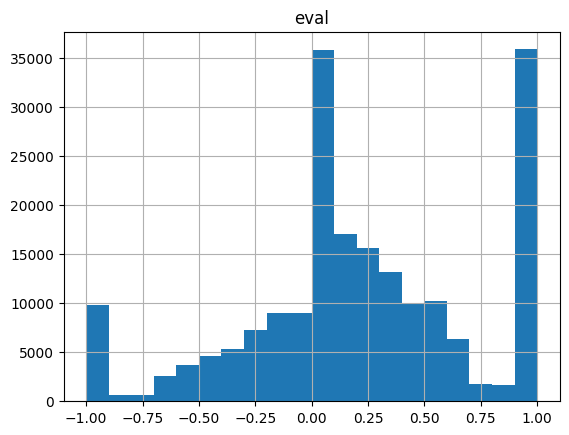

In [93]:
from helpers.data import prepare_chess_frame

df = prepare_chess_frame(df, True)
df.hist(column="eval", bins=20)
df.describe()

In [94]:
import torch
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import Compose
from helpers.fen import fen_to_bitboard

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


class FenToBits(object):
    def __init__(self, merge_colors: bool):
        self.merge_colors = merge_colors
        
    def __call__(self, sample):
        return {"eval": sample["eval"], "board": fen_to_bitboard(sample["fen"], self.merge_colors)}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        board, eval = sample["board"], sample["eval"]
        return {"board": torch.from_numpy(board).float(), "eval": torch.tensor([eval]).float()}


class ToTuple(object):
    def __call__(self, sample):
        return sample["board"], sample["eval"]


class ChessDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        df = pd.read_csv(csv_file)
        self.df = prepare_chess_frame(df, normalize=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        row = self.df.iloc[idx]
        sample = {"fen": row["fen"], "eval": row["eval"]}

        if self.transform:
            sample = self.transform(sample)

        return sample


BATCH_SIZE = 256
chess_dataset = ChessDataset(
    csv_file="./data/evals.csv", transform=Compose([FenToBits(merge_colors=True), ToTensor(), ToTuple()])
)
train_set, test_set = random_split(chess_dataset, [0.8, 0.2])
train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE)

Using cuda device


In [95]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_shape):
        super().__init__()

        activation_f = nn.ReLU

        conv_layers = 1
        dense_layers = 3
        conv_sizes = [114]
        in_size = input_shape[0]
        kernel = 3
        stack = [
            nn.Conv2d(input_shape[0], conv_sizes[0], kernel_size=kernel),
            activation_f(),
            nn.Flatten(),
        ]
        in_size = conv_sizes[-1] *  (8 - conv_layers * 2) ** 2
        dense_sizes = [57, 110, 62]
        for i in range(dense_layers):
            out_size = dense_sizes[i]
            l = nn.Linear(in_size, out_size)
            in_size = out_size
            stack.extend([l, activation_f()])
        stack.append(nn.Linear(in_size, 1))
        self.stack = nn.Sequential(*stack)

    def forward(self, x):
        logits = self.stack(x)
        return logits


dataset_shape = chess_dataset[0][0].shape

model = NeuralNetwork(input_shape=dataset_shape).to(device)


print(model)



loss_fn = nn.MSELoss()


optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0005)

NeuralNetwork(
  (stack): Sequential(
    (0): Conv2d(6, 114, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=4104, out_features=57, bias=True)
    (4): ReLU()
    (5): Linear(in_features=57, out_features=110, bias=True)
    (6): ReLU()
    (7): Linear(in_features=110, out_features=62, bias=True)
    (8): ReLU()
    (9): Linear(in_features=62, out_features=1, bias=True)
  )
)


In [96]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss


def test(dataloader, model, loss_fn):
    # size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(
        f"Test Error: Avg loss: {test_loss:>8f} \n"
    )
    return test_loss

In [97]:
history={"train_loss": [], "test_loss": []}
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss = test(test_dataloader, model, loss_fn)
    history["train_loss"].append(train_loss)
    history["test_loss"].append(test_loss)
print("Done!")

date_string = datetime.today().strftime('%Y_%m_%d-%H-%M')
torch.save(model.state_dict(), f'models/best_{date_string}.pt')

Epoch 1
-------------------------------
loss: 0.306340  [  256/160000]
loss: 0.214466  [25856/160000]
loss: 0.235454  [51456/160000]
loss: 0.233105  [77056/160000]
loss: 0.189199  [102656/160000]
loss: 0.179206  [128256/160000]
loss: 0.188405  [153856/160000]
Test Error: Avg loss: 0.176311 

Epoch 2
-------------------------------
loss: 0.163207  [  256/160000]
loss: 0.185025  [25856/160000]
loss: 0.197260  [51456/160000]
loss: 0.192647  [77056/160000]
loss: 0.163166  [102656/160000]
loss: 0.166839  [128256/160000]
loss: 0.168502  [153856/160000]
Test Error: Avg loss: 0.159935 

Epoch 3
-------------------------------
loss: 0.134220  [  256/160000]
loss: 0.169111  [25856/160000]
loss: 0.177549  [51456/160000]
loss: 0.176779  [77056/160000]
loss: 0.149088  [102656/160000]
loss: 0.151867  [128256/160000]
loss: 0.148717  [153856/160000]
Test Error: Avg loss: 0.152609 

Epoch 4
-------------------------------
loss: 0.118410  [  256/160000]
loss: 0.137534  [25856/160000]
loss: 0.171183  [51

Last epoch train loss: 0.12404107302427292
Last epoch test loss:  0.1475300246932704


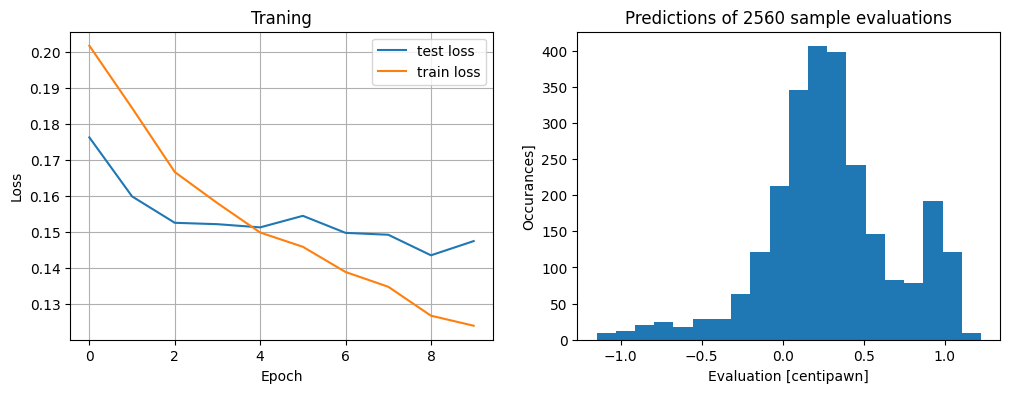

In [98]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

print(f"Last epoch train loss: {history['train_loss'][-1]}")
print(f"Last epoch test loss:  {history['test_loss'][-1]}")

arr = np.array([h for h in history["test_loss"]])
xs = np.arange(len(arr))
axes[0].plot(xs, arr, label="test loss")
arr = np.array([h.cpu().detach().numpy() for h in history["train_loss"]])
xs = np.arange(len(arr))
axes[0].plot(xs, arr, label="train loss")
axes[0].grid()
axes[0].legend()
axes[0].set_title("Traning")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")

model.eval()
preds = []
i = 0
for X, y in train_dataloader:
    X = X.to(device)
    y = model(X)
    preds.append(y.cpu().detach().numpy())
    i += 1
    if i == 10:
        break

preds = np.array(preds).flatten()
axes[1].hist(preds, 20)
axes[1].set_title(f"Predictions of {len(preds)} sample evaluations")
axes[1].set_xlabel("Evaluation [centipawn]")
axes[1].set_ylabel("Occurances]")

plt.show()